In [20]:
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Nadam
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras import regularizers

from sklearn.model_selection import train_test_split
from skimage.transform import resize as imresize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from datetime import datetime
#from tqdm import tqdm

In [2]:
st = datetime.now()
st

datetime.datetime(2019, 11, 5, 12, 57, 20, 494142)

In [3]:
BATCH_SIZE = 32
EPOCHS = 200
RANDOM_STATE = 47
INPUT_SHAPE = (100, 100, 3)

In [4]:
CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

In [5]:
def get_callbacks(tb_log_dir=f'.{os.sep}log{os.sep}tensorboard', patience=5):
    lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=1e-5, patience=patience, verbose=1)
    tboard = TensorBoard(log_dir=tb_log_dir)
    es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto')
    return [es, lr_reduce, tboard]

In [6]:
def get_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=INPUT_SHAPE, name='conv_1', kernel_initializer='glorot_normal',
                     kernel_regularizer=regularizers.l2(0.01)))
    #model.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
    model.add(BatchNormalization(name='batch_norm_1'))
    model.add(Dropout(0.25, name='drop_1'))

    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu', name='conv_2',
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2),name='max_2'))
    model.add(BatchNormalization(name='batch_norm_2'))
    model.add(Dropout(0.25, name='drop_2'))

    model.add(Conv2D(128, kernel_size=(3, 3),
                     activation='relu', name='conv_3',
                     kernel_regularizer=regularizers.l2(0.01)))
    #model.add(MaxPooling2D(pool_size=(2, 2),name='max_3'))
    model.add(BatchNormalization(name='batch_norm_3'))
    model.add(Dropout(0.25, name='drop_3'))

    model.add(Conv2D(256, kernel_size=(3, 3),
                     activation='relu', name='conv_4',
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2),name='max_4'))
    model.add(BatchNormalization(name='batch_norm_4'))
    model.add(Dropout(0.50, name='drop_4'))
    
    model.add(Conv2D(512, kernel_size=(3, 3),
                     activation='relu', name='conv_5',
                     kernel_regularizer=regularizers.l2(0.01)))
    #model.add(MaxPooling2D(pool_size=(2, 2),name='max_5'))
    model.add(BatchNormalization(name='batch_norm_5'))
    model.add(Dropout(0.25, name='drop_5'))

    model.add(Conv2D(1024, kernel_size=(3, 3),
                     activation='relu', name='conv_6',
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization(name='batch_norm_6'))
    model.add(Dropout(0.50, name='drop_6'))
    
    model.add(Conv2D(1024, kernel_size=(3, 3),
                     activation='relu', name='conv_7',
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2),name='max_7'))
    model.add(BatchNormalization(name='batch_norm_7'))
    model.add(Dropout(0.25, name='drop_7'))

#     model.add(Conv2D(1024, kernel_size=(3, 3),
#                      activation='relu', name='conv_7',
#                      kernel_regularizer=regularizers.l2(0.01)))
#     model.add(MaxPooling2D(pool_size=(2, 2),name='max_7'))
#     model.add(BatchNormalization(name='batch_norm_7'))
#     model.add(Dropout(0.50, name='drop_7'))    
    
    model.add(Flatten())

    model.add(Dense(128, activation='relu',name='dense_11'))
    model.add(BatchNormalization(name='batch_norm_11'))
    model.add(Dropout(0.50, name='drop_11'))

    model.add(Dense(len(CLASS), activation='softmax',name='dense_12'))
    
    #Set the loss function and optimizer for the model training
    optimizer = Adam()    
    model.compile(loss=categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    model.summary()
    return model

In [7]:
# get image tag
def img_label(path):
    return str(str(path.split(os.sep)[-1]))

In [8]:
# get plant class on image
def img_class(path):
    return str(path.split(os.sep)[-2])

In [9]:
def img_reshape(img):
    img = imresize(img, INPUT_SHAPE)
    return img

In [10]:
# fill train and test dict
def fill_dict(paths, some_dict):
    text = ''
    if 'train' in paths[0]:
        text = 'Start fill train_dict'
    elif 'test' in paths[0]:
        text = 'Start fill test_dict'

    #for p in tqdm(paths, ascii=True, ncols=85, desc=text):
    for p in paths:
        img = imageio.imread(p)
        img = img_reshape(img)
        some_dict['image'].append(img)
        some_dict['label'].append(img_label(p))
        if 'train' in paths[0]:
            some_dict['class'].append(img_class(p))

    return some_dict

In [11]:
# read image from dir. and fill train and test dict
def reader():
    file_ext = []
    train_path = []
    test_path = []

    for root, dirs, files in os.walk(f'.{os.sep}data'):
        if dirs != []:
            print('Root:\n'+str(root))
            print('Dirs:\n'+str(dirs))
        else:         
            for f in files:
                ext = os.path.splitext(str(f))[1][1:]

                if ext not in file_ext:
                    file_ext.append(ext)

                if 'train' in root:
                    path = os.path.join(root, f)
                    train_path.append(path)
                elif 'test' in root:
                    path = os.path.join(root, f)
                    test_path.append(path)
    train_dict = {
        'image': [],
        'label': [],
        'class': []
    }
    test_dict = {
        'image': [],
        'label': []
    }
    
    train_dict = fill_dict(train_path, train_dict)
    test_dict = fill_dict(test_path, test_dict)
    return train_dict, test_dict

Original Image Shape =  (484, 484, 3)


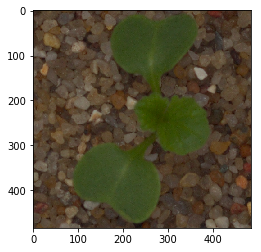

Reshaped Image Shape =  (100, 100, 3)


C:\Users\Beejal\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Beejal\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


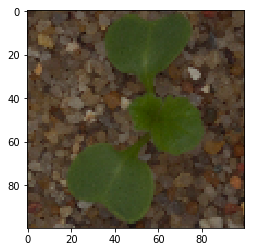

In [12]:
# Original images are bigger like this one is 484 * 484. Also these images differ in sizes. 
# We need feed our model with same sized images. Here we bring image size to 51*51. Let's look at one of the images
# to visually understand how does an image look like before & after resize.

f = '0a7e1ca41.png'
root = f'.{os.sep}data{os.sep}train{os.sep}Charlock'
p = os.path.join(root, f)
img = imageio.imread(p)
print('Original Image Shape = ', img.shape)
plt.imshow(img)
plt.show()

img = img_reshape(img)
print('Reshaped Image Shape = ', img.shape)
plt.imshow(img)

plt.show()
plt.close()

# It appears that the image is slightly faded

In [13]:
train_dict, test_dict = reader()
train_img = np.array(train_dict['image'])
train_lbl = to_categorical(np.array([CLASS[l] for l in train_dict['class']]))

X_test = np.array(test_dict['image'])
label = test_dict['label']

Root:
.\data
Dirs:
['test', 'train']
Root:
.\data\train
Dirs:
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [14]:
callbacks = get_callbacks(patience=6)
model = get_model()
#gmodel.load_weights(filepath='model_weight_Adam.hdf5')
x_train, x_valid, y_train, y_valid = train_test_split(
                                                    train_img,
                                                    train_lbl,
                                                    shuffle=True,
                                                    train_size=0.8,
                                                    random_state=RANDOM_STATE
                                                    )
gen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True
)
model.fit_generator(gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
           steps_per_epoch=len(x_train)/BATCH_SIZE,
           epochs=EPOCHS,
           verbose=1,
           shuffle=True,
           validation_data=(x_valid, y_valid),
           callbacks=callbacks)

C:\Users\Beejal\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 98, 98, 32)        128       
_________________________________________________________________
drop_1 (Dropout)             (None, 98, 98, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 96, 96, 64)        18496     
_________________________________________________________________
max_2 (MaxPooling2D)         (None, 48, 48, 64)        0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 48, 48, 64)        256       
_________________________________________________________________
drop_2 (Dropout)             (None, 48, 48, 64)      

Epoch 21/200
119/118 [==============================] - 51s 432ms/step - loss: 1.1728 - accuracy: 0.6839 - val_loss: 1.1227 - val_accuracy: 0.6811
Epoch 22/200
119/118 [==============================] - 51s 432ms/step - loss: 1.1763 - accuracy: 0.6861 - val_loss: 1.0898 - val_accuracy: 0.7368
Epoch 23/200
119/118 [==============================] - 51s 432ms/step - loss: 1.1386 - accuracy: 0.6958 - val_loss: 1.4243 - val_accuracy: 0.6211
Epoch 24/200
119/118 [==============================] - 51s 433ms/step - loss: 1.1647 - accuracy: 0.6863 - val_loss: 0.8447 - val_accuracy: 0.8116
Epoch 25/200
119/118 [==============================] - 51s 433ms/step - loss: 1.0678 - accuracy: 0.7268 - val_loss: 1.0474 - val_accuracy: 0.7326
Epoch 26/200
119/118 [==============================] - 51s 433ms/step - loss: 1.1049 - accuracy: 0.7129 - val_loss: 0.8775 - val_accuracy: 0.7632
Epoch 27/200
119/118 [==============================] - 52s 433ms/step - loss: 1.0496 - accuracy: 0.7282 - val_loss: 0

119/118 [==============================] - 51s 432ms/step - loss: 0.5613 - accuracy: 0.8676 - val_loss: 0.4895 - val_accuracy: 0.8853

Epoch 00074: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 75/200
119/118 [==============================] - 51s 432ms/step - loss: 0.5604 - accuracy: 0.8621 - val_loss: 0.4913 - val_accuracy: 0.8863
Epoch 76/200
119/118 [==============================] - 51s 432ms/step - loss: 0.5714 - accuracy: 0.8579 - val_loss: 0.4887 - val_accuracy: 0.8884
Epoch 00076: early stopping


In [32]:
y_pred = model.predict(x_train, verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = y_train.argmax(axis=-1)

print("Training Report (80% Training Data) :")
print(classification_report(y_true, y_pred, target_names=CLASS.keys()))

3800/3800 [==============================] - 14s 4ms/step
Training Report (80% Training Data) :
                           precision    recall  f1-score   support

              Black-grass       0.65      0.53      0.59       206
                 Charlock       0.95      0.92      0.93       317
                 Cleavers       0.98      0.87      0.92       226
         Common Chickweed       0.95      0.97      0.96       489
             Common wheat       0.93      0.95      0.94       183
                  Fat Hen       0.94      0.99      0.97       392
         Loose Silky-bent       0.84      0.87      0.85       522
                    Maize       0.82      0.99      0.90       186
        Scentless Mayweed       0.96      0.91      0.93       408
          Shepherds Purse       0.86      0.86      0.86       189
Small-flowered Cranesbill       0.96      0.94      0.95       384
               Sugar beet       0.92      0.95      0.93       298

                 accuracy      

In [33]:
# Following should tell us which images are misinterpreted
pd.DataFrame(confusion_matrix(y_true, y_pred), columns=CLASS.keys(), index=CLASS.keys())

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
Black-grass,110,0,0,0,7,0,87,1,0,0,0,1
Charlock,0,291,2,0,2,1,0,16,0,0,0,5
Cleavers,0,13,197,1,1,2,0,2,0,0,2,8
Common Chickweed,0,0,1,472,3,0,1,0,1,7,3,1
Common wheat,0,0,1,1,174,5,0,0,0,0,0,2
Fat Hen,0,0,0,2,0,388,0,1,0,0,1,0
Loose Silky-bent,59,0,0,1,0,2,454,0,2,2,2,0
Maize,0,0,0,0,0,1,0,184,1,0,0,0
Scentless Mayweed,0,1,0,10,0,1,1,0,371,18,3,3
Shepherds Purse,0,0,0,7,0,1,0,1,13,163,3,1


In [34]:
y_pred = model.predict(x_valid, verbose=1)
y_pred = y_pred.argmax(axis=-1)

y_true = y_valid.argmax(axis=-1)

print("Validation Report (20% Training Data):")
print(classification_report(y_true, y_pred, target_names=CLASS.keys()))

950/950 [==============================] - 4s 4ms/step
Validation Report (20% Training Data):
                           precision    recall  f1-score   support

              Black-grass       0.68      0.47      0.56        57
                 Charlock       0.91      0.84      0.87        73
                 Cleavers       0.98      0.84      0.90        61
         Common Chickweed       0.92      0.95      0.94       122
             Common wheat       0.90      1.00      0.95        38
                  Fat Hen       0.88      0.99      0.93        83
         Loose Silky-bent       0.82      0.89      0.85       132
                    Maize       0.72      0.97      0.83        35
        Scentless Mayweed       0.95      0.86      0.90       108
          Shepherds Purse       0.85      0.79      0.81        42
Small-flowered Cranesbill       0.95      0.96      0.95       112
               Sugar beet       0.93      0.98      0.96        87

                 accuracy        

In [35]:
# Following should tell us which images are misinterpreted
pd.DataFrame(confusion_matrix(y_true, y_pred), columns=CLASS.keys(), index=CLASS.keys())

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
Black-grass,27,0,0,0,3,3,23,0,0,0,1,0
Charlock,0,61,0,0,0,2,0,9,0,0,0,1
Cleavers,0,4,51,1,0,2,0,0,0,0,1,2
Common Chickweed,0,0,0,116,0,0,1,1,1,0,2,1
Common wheat,0,0,0,0,38,0,0,0,0,0,0,0
Fat Hen,0,0,0,0,0,82,0,0,0,0,1,0
Loose Silky-bent,13,0,0,0,1,0,117,0,1,0,0,0
Maize,0,0,0,0,0,1,0,34,0,0,0,0
Scentless Mayweed,0,1,0,5,0,1,1,0,93,6,1,0
Shepherds Purse,0,0,0,4,0,0,0,1,3,33,0,1


In [17]:
model.save_weights('Weights_005.h5')

In [18]:
end = datetime.now()

In [19]:
total_time = end - st
total_time

datetime.timedelta(seconds=4064, microseconds=923954)

In [ ]:
# To improve further, I would focus on Black-grass, Loose Silky-bent, Maize, Fat Hen